In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import DADOS_ORIGINAIS, DADOS_TRATADOS
from src.helpers import analisar_cardinalidade, cramers_v

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(palette='bright')

In [2]:
# Importação da base de dados
df = pd.read_csv(DADOS_ORIGINAIS).rename(columns={'poisonous': 'class'})
df.head(3)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e


### Entendimento da base de dados

Em primeira análise, percebe-se que a base de dados lida com 22 variáveis e 1 alvo, todos categóricos.

Além disso, possui uma única coluna com valores nulos, sendo ela a coluna `stalk-root`, com cerca de 30.53% de seus dados ausentes.

In [3]:
# Colunas com valores nulos
for col in df.columns:
    nulls = df[col].isnull().sum()
    if nulls:
        proportion = df[col].isnull().mean() * 100
        print(f"{col}: {nulls} nulls ({proportion:.2f}%)")

stalk-root: 2480 nulls (30.53%)


In [4]:
# Tipos de dados das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

### Correção de tipos

Os tipos de dados foram ajustados para `category` a fim de gerar mais economia de memória e performance na execução do código.

In [5]:
# Correção de tipos
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cap-shape                 8124 non-null   category
 1   cap-surface               8124 non-null   category
 2   cap-color                 8124 non-null   category
 3   bruises                   8124 non-null   category
 4   odor                      8124 non-null   category
 5   gill-attachment           8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                5644 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   catego

### Análise de cardinalidade e balanceamento das variáveis

O gráfico 1 representa o balanceamento entre as categorias que compoem cada variável.
A tabela de cardinalidade mostra a quantidade de categorias por classe, bem como a porcentagem da proporção da categoria predominante.

A partir disso, podemos observar:

- Variáveis com alta cardinalidade (10 ou mais categorias):
    - gill-color: 12 categorias
    - cap-color: 10 categorias

- Variáveis com alto desbalanceamento (predominância de um único valor > 80%):
    - veil-type: 100.00%
    - veil-color: 97.54%
    - gill-attachment: 97.42%
    - ring-number: 92.17%
    - gill-spacing: 83.85%

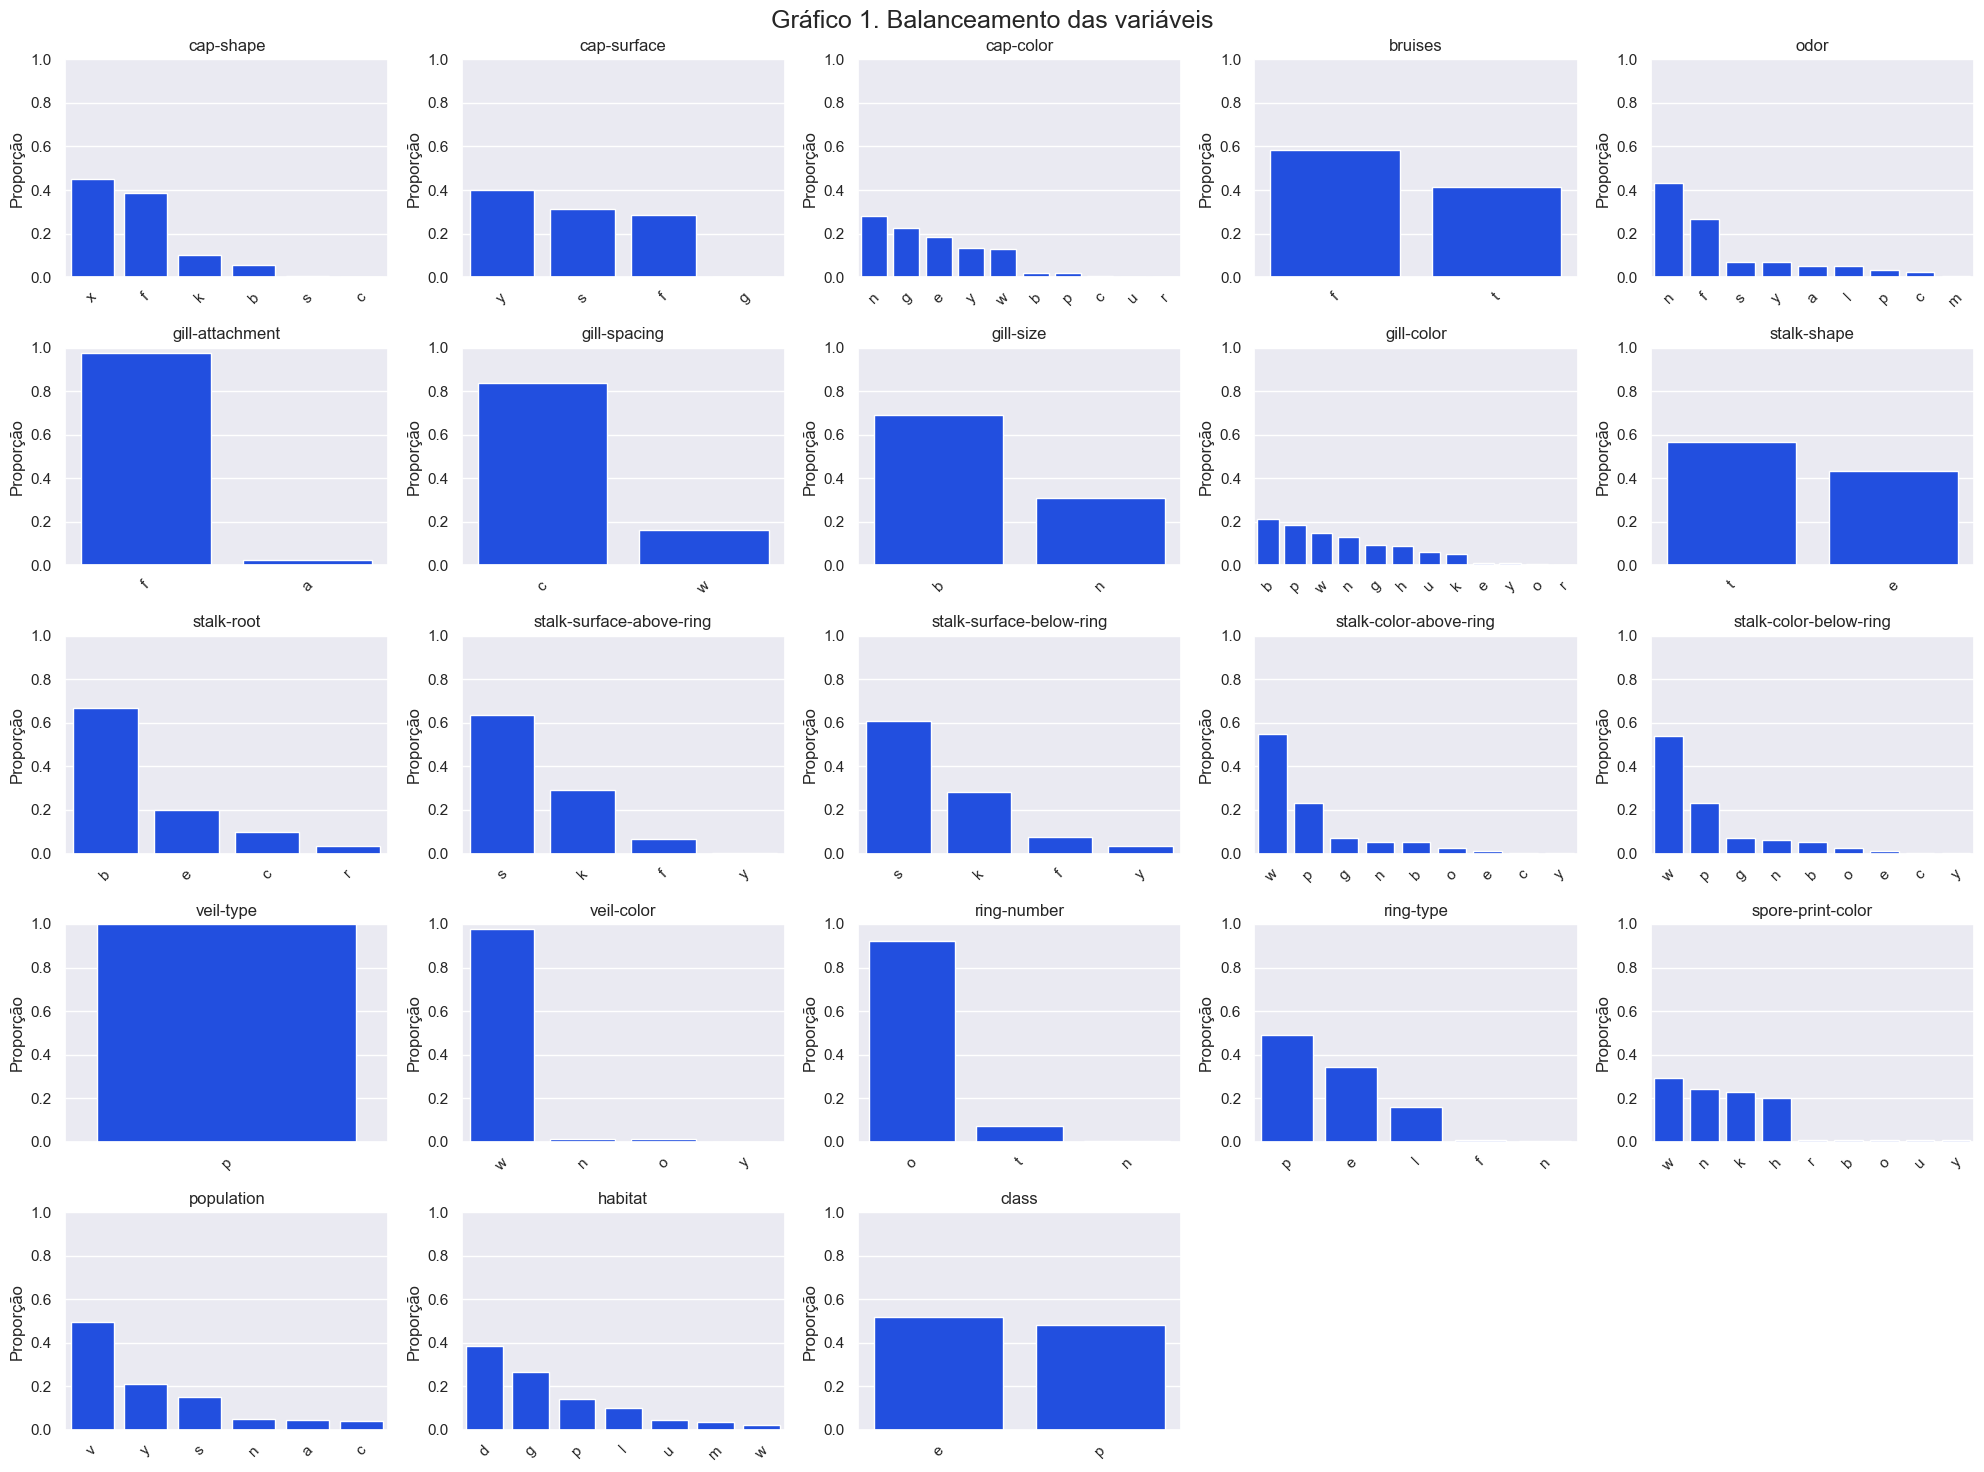

In [6]:
# Visualização do balanceamento entre valores das colunas
n_cols = 5
n_rows = (len(df.columns) // n_cols) + (1 if len(df.columns) % n_cols != 0 else 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    proporcoes = df[col].value_counts(normalize=True)
    sns.barplot(x=proporcoes.index, y=proporcoes.values, ax=axes[i], order=proporcoes.index)
    axes[i].set_title(col)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Proporção')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Gráfico 1. Balanceamento das variáveis', fontsize=18)

plt.tight_layout()
plt.show()

In [7]:
# Análise de cardinalidade das colunas
df_cardinalidade = analisar_cardinalidade(df)
display(df_cardinalidade)

,feature,n_categorias,pct_valor_mais_frequente
0,gill-color,12,21.27
1,cap-color,10,28.11
2,odor,9,43.43
3,spore-print-color,9,29.39
4,stalk-color-above-ring,9,54.95
5,stalk-color-below-ring,9,53.96
6,habitat,7,38.75
7,cap-shape,6,45.00
8,population,6,49.73
9,ring-type,5,48.84


In [8]:
# Features com um único valor com predominância > 80%
df_cardinalidade[df_cardinalidade['pct_valor_mais_frequente'] > 80].sort_values(by=['pct_valor_mais_frequente'], ascending=False)

,feature,n_categorias,pct_valor_mais_frequente
22,veil-type,1,100.00
11,veil-color,4,97.54
18,gill-attachment,2,97.42
15,ring-number,3,92.17
16,gill-spacing,2,83.85


### Análise de correlação entre variáveis

Foi utilizado o V de Cramer como parâmetro para mensurar a correlação entre as variáveis, que pode ser visualizado a partir da matriz de correlação do Gráfico 2.

A partir dessa análise, destaca-se o alto grau de correlação da variável `gill-attachment` com as variáveis:
- `stalk-color-above-ring`: 0.98
- `stalk-color-below-ring`: 0.98
- `veil-color`: 0.95

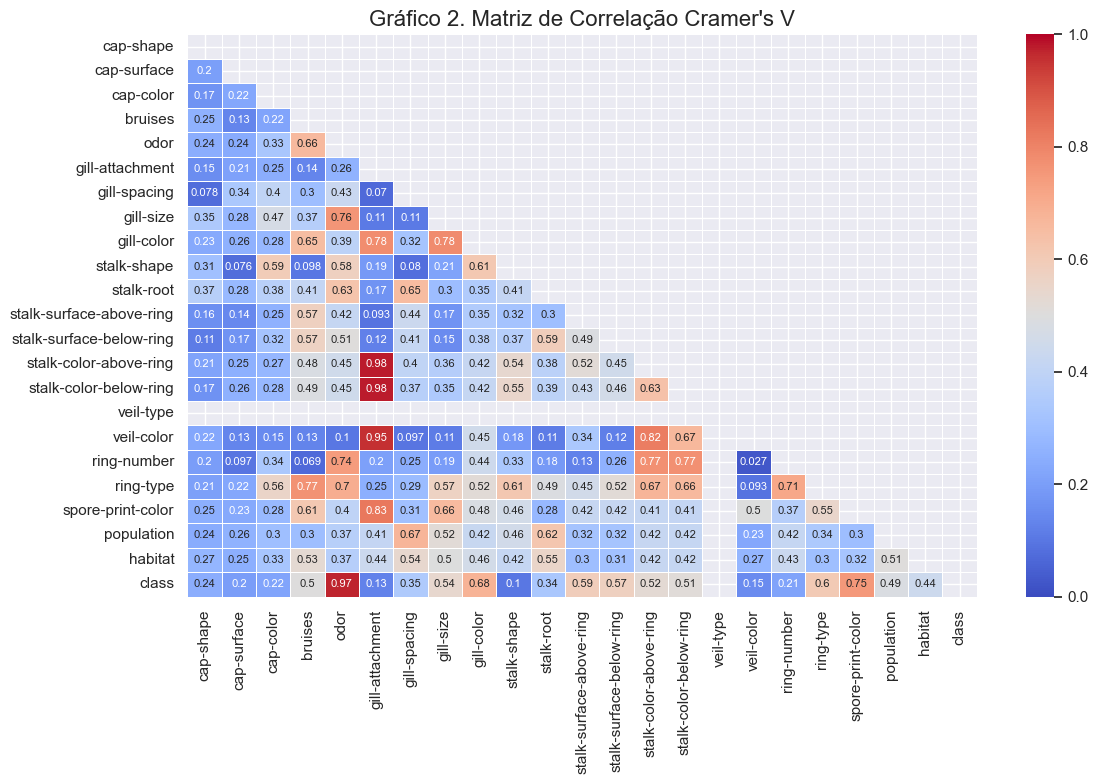

In [9]:
# Cria matriz de correlação usando Cramer's V
features = df.columns.tolist()
cramers_v_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        if i == j:
            cramers_v_matrix.loc[i, j] = 1.0
        else:
            cramers_v_matrix.loc[i, j] = cramers_v(df[i], df[j])

# Converte para valores numéricos
cramers_v_matrix = cramers_v_matrix.astype(float)

# Visualização da matriz
plt.figure(figsize=(12, 8))
mask = np.triu(cramers_v_matrix)
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask, vmax=1, vmin=0, annot_kws={'fontsize': 8})
plt.title('Gráfico 2. Matriz de Correlação Cramer\'s V', fontsize=16)
plt.tight_layout()
plt.show()

### Análise de correlação com o target

Foi analisado individualmente como cada variável se correlaciona com o target, havendo-se destaque para:
- `odor`: 0.9705 de correlação
- `spore-print-color`: 0.7520 de correlação

A partir dessa análise, criou-se o gráfico 3 para representar o balanceamento entre as 4 classes mais correlacionadas com o target e seus valores.

In [10]:
# Variáveis mais correlacionadas com o target
class_correlations = cramers_v_matrix[['class']].sort_values(by='class', ascending=False).drop('class')
display(class_correlations)

,class
odor,0.970558
spore-print-color,0.752036
gill-color,0.679877
ring-type,0.602900
stalk-surface-above-ring,0.587666
stalk-surface-below-ring,0.574551
gill-size,0.539677
stalk-color-above-ring,0.523943
stalk-color-below-ring,0.513799
bruises,0.501188


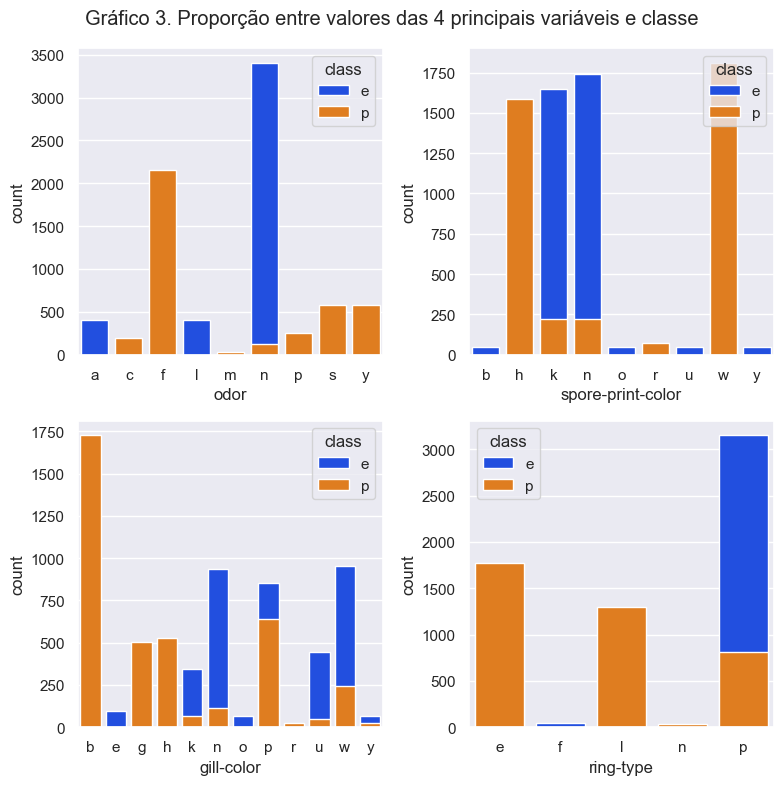

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
axes = axes.flatten()

for feature, ax in zip(class_correlations[:4].index, axes):
    sns.countplot(x=feature, hue='class', data=df, ax=ax, dodge=False)

fig.suptitle('Gráfico 3. Proporção entre valores das 4 principais variáveis e classe')
plt.tight_layout()
plt.show()

### Remoção de colunas desbalanceadas

A variável `stalk-root` apresenta 30% de valores ausentes. Considerando que:
- A imputação geraria ruído, pois os valores são categorias não ordinalmente interpretáveis.
- A coluna tem baixa correlação com a variável-alvo (`class`).

Optou-se por removê-la para evitar introdução de ruído desnecessário.

Além disso, foi estabelecido que colunas com uma predominância maior que 95% em um único valor, por possuírem alto viés e desbalanceamento, também seriam removidas da análise


In [12]:
# Remoção da coluna 'stalk-root' devido a quantidade de valores nulos
df = df.drop(columns=['stalk-root'])
print('Coluna stalk-root removida: alto índice de valores nulos')

# Remoção de colunas com predominância de um único valor > 95%
variaveis_predominantes = df_cardinalidade[df_cardinalidade['pct_valor_mais_frequente'] > 95]['feature'].tolist()
df = df.drop(columns=variaveis_predominantes)
for var in variaveis_predominantes:
    print(f'Coluna {var} removida: predominância de único valor')

Coluna stalk-root removida: alto índice de valores nulos
Coluna veil-color removida: predominância de único valor
Coluna gill-attachment removida: predominância de único valor
Coluna veil-type removida: predominância de único valor


In [13]:
# Exportação da base tratada
df.to_csv(DADOS_TRATADOS, index=False)